In [2344]:
#todo: check how would the context of soft margin look like, compared to the cell below

### Hard Margin SVM Context:

In SVMs, particularly in the context of hard margin SVMs, the goal is to find a hyperplane that perfectly separates the data points of two classes. The labels are typically represented as $-1$ and $1$ rather than $0$ and $1$ because:

1. **Mathematical Convenience**:
   - Using labels $-1$ and $1$ simplifies the formulation of the optimization problem and the corresponding constraints. The margin can be described uniformly for both classes.
   - The decision function is typically of the form $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$, and the classification rule is based on the sign of this function. For a correctly classified point $\mathbf{x}_i$, the product $y_i \cdot f(\mathbf{x}_i)$ should be positive, which leads to the constraint:
     $
     y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1
     $
     This constraint holds naturally when $y_i$ is $-1$ or $1$.

2. **Margin Definition**:
   - The margin is defined as the distance between the closest points (support vectors) and the hyperplane. For a hard margin SVM, this margin is maximized while ensuring that all data points are correctly classified.
   - With the transformation to $-1$ and $1$ labels, the SVM can enforce the hard margin constraint uniformly for both classes without needing additional conditions for different label values.

### The Transformation:
- The transformation $t_i = 2y_i - 1$ maps:
  - $y_i = 0$ to $t_i = -1$
  - $y_i = 1$ to $t_i = 1$

This ensures that the SVM can apply the margin constraints uniformly for both classes, treating them symmetrically in the optimization process.

### In Summary:
The transformation of the labels from $y \in \{0, 1\}$ to $t \in \{-1, 1\}$ is a crucial step in setting up the SVM for hard margin classification. It ensures that the mathematical formulation of the SVM is consistent and simplifies the application of the margin constraints, which are fundamental to the SVM's operation.

In [2345]:
import numpy as np
from matplotlib import pyplot as plt

# ------------------------------------------------------------------------------------------------
# EXAMPLE 1
Mainly based on the books author's code. But little adjustments were done from my side.

In [2346]:
from sklearn import datasets

# CREATE DATA
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [2347]:
X.shape, y.shape

((150, 2), (150,))

In [2348]:
# check what unique values are in y
y.unique()

array([False,  True])

In [2349]:
y.value_counts()

target
False    100
True      50
Name: count, dtype: int64

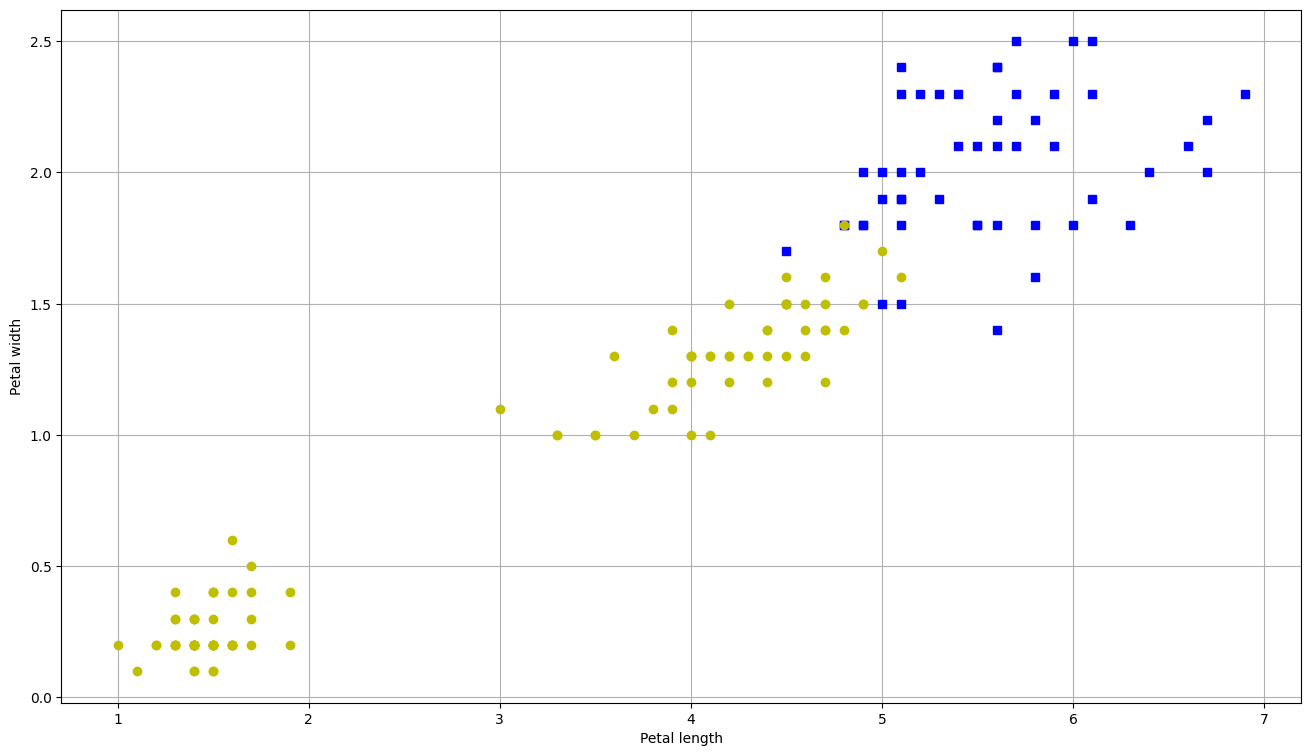

In [2350]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs") # blue squares
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo") # yellow circles
plt.xlabel("Petal length")
plt.ylabel("Petal width")
# plt.gca().set_aspect("equal") # make aspect ratio equal of x and y axis
plt.grid()

In [2351]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [2352]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [2353]:
# CREATE ESTIMATOR
from sklearn.base import BaseEstimator


class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=100, n_epochs=1000):
        """
        This class uses soft margin SVM to classify the data. It uses hinge loss as a loss function.
        This means that if you have parameter "C" then you are using soft margin SVM.
        
        :param C: Regularization parameter 
        :param eta0: Learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param random_state: 
        """
        
        # I you are confused why some "selfs" have different colors. 
        # It is because of the base class which has its own color for self.
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.Js = [] # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
        
        # todo: smazat
        self.X_t_sv = None
        self.t_sv = None
        
    def eta(self, epoch):
        """
        This function calculates the learning rate at each epoch.
        The greater the epoch, the smaller the learning rate.

        :param epoch: Numer of a epoch in the training process
        :returns: Learning rate
        """
        return self.eta0 / (epoch + self.eta_d)
    
    @staticmethod
    def transform_datapoints_to_positive_and_negative(X, y):
        """
        This function converts the original y data to column vector and then -1 and 1 from False and True 
        (meaning 0 and 1, because the False is 0 and True is 1)
        and multiplies the feature dataset with the converted y data.
        
        Example (Data do not make sense, important is the conversion):
        X = np.array([[1, 2], [3, 4], [5, 6]])
        y = [True, False, True]
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        X_t, t
        
        Result:
        (array([[ 1.,  2.],
                [-3., -4.],
                [ 5.,  6.]]),
         array([[ 1.],
                [-1.],
                [ 1.]]))
                
        :param X: Feature dataset
        :param y: Labels
        :returns: Converted feature dataset and labels
        """
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        # print("X_t", X_t.shape, X_t, "t", t.shape, t, sep="\n")
        return X_t, t
    
    def select_margin_violators(self, X_t, t):
        """
        This function selects the margin violators.
        
        :param X_t: Feature dataset, which in this case is original dataset multiplied by -1 and 1.
        :param t: Labels, which are either -1 or 1.

        Returns:

        """
        support_vectors_idx = (X_t.dot(self.coef_) + t * self.intercept_ < 1).ravel()
        X_t_sv = X_t[support_vectors_idx]
        t_sv = t[support_vectors_idx]
        
        # index = t_sv.ravel() >= 0
        # X_t_sv = X_t_sv[index]
        # t_sv = t_sv[index]
        return X_t_sv, t_sv, support_vectors_idx

    def fit(self, X, y):
        """
        This function fits the model to the training data. It returns "self" due 
        to the convenient way like

        chaining: 
        "model = SomeModel().fit(X, y).predict(X_test)" 

        or in pipeline:
        "from sklearn.pipeline import Pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', SomeModel())
        ])
        pipeline.fit(X_train, y_train)"


        :param X: Feature dataset
        :param y: Labels
        :returns: self
        """
        # Random initialization of weights and bias
        self.coef_ = np.random.randn(X.shape[1], 1)  # number of feature weights
        self.intercept_ = np.array([0])
        
        X_t, t = self.transform_datapoints_to_positive_and_negative(X, y)
    
        # Training
        for epoch in range(self.n_epochs):
            X_t_sv, t_sv, _ = self.select_margin_violators(X_t, t)
            if epoch == self.n_epochs - 1:
                self.X_t_sv = X_t_sv
                self.t_sv = t_sv
        
            # Losses (Just for visualisation) --------------------------------
            J = 1 / 2 * (self.coef_ * self.coef_).sum() + self.C * ((1 - X_t_sv.dot(self.coef_)).sum() - self.intercept_ * t_sv.sum())
            self.Js.append(J)
            # ----------------------------------------------------------------

            # compute gradients
            w_gradient_vector = self.coef_ - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()

            # update weights and bias
            self.coef_ = self.coef_ - self.eta(epoch) * w_gradient_vector
            self.intercept_ = self.intercept_ - self.eta(epoch) * b_derivative

        _, _, support_vectors_idx = self.select_margin_violators(X_t, t)
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [2354]:
orig = [10, 20, 30, 40, 50]
indexos = [False, False, True, True, False]
orig = np.array(orig)
orig[indexos]

array([30, 40])

In [2355]:
# TRAIN MODEL

svm = MyLinearSVC(C=1, eta0=1, eta_d=1000, n_epochs=20000)

In [2356]:
svm.fit(X_train, y_train)

MyLinearSVC(eta_d=1000, n_epochs=20000)

In [2357]:
svm.intercept_, svm.coef_

(array([-2.7675077]),
 array([[2.17189226],
        [2.28844618]]))

In [2358]:
# EVALUATE MODEL
from sklearn.metrics import accuracy_score

y_pred = svm.predict(X_test)
y_pred.shape, y_test.shape


((30, 1), (30,))

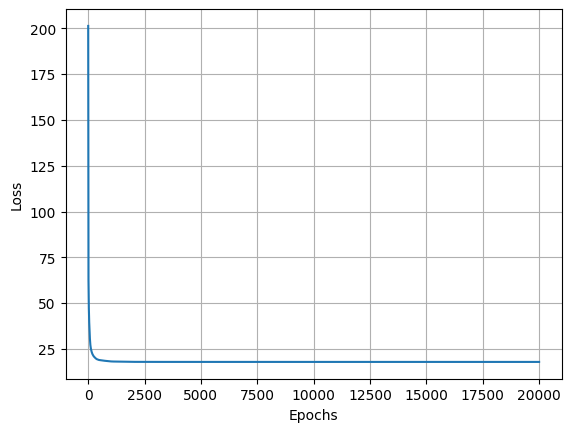

In [2359]:
plt.plot(range(svm.n_epochs), svm.Js)
# plt.axis((0, svm.n_epochs, 0, 200))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [2360]:
def plot_decision_boundary_from_weights(model, X_plot, y_plot, X_test, xlabel="Feature 1", ylabel="Feature 2"):
    """
    Plots all the points from the complete dataset in the background and then plot decision boundary based on the test dataset.

    """
    # Extract weights and bias from the model
    w = model.coef_
    b = model.intercept_
    
    plt.figure(figsize=(16, 9))

    # Plot the data points
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap="plasma")
    # plt.scatter(model.X_t_sv[:, 0], model.X_t_sv[:, 1], 
    #             s=180, 
    #             facecolors='#FF0000', 
    #             zorder=-1) # Makes the circles behind the data points    
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=180, 
                facecolors='#FF0000', 
                zorder=-1) # Makes the circles behind the data points

    # Compute the decision boundary
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, 100)
    yy = -(w[0] * xx + b) / w[1]

    # Compute 
    margin = 2 / np.linalg.norm(w)
    gutter_up = yy + margin
    gutter_down = yy - margin

    # plot support vectors
    plt.plot(xx, gutter_up, "k--", linewidth=2, label="Support Vectors")
    plt.plot(xx, gutter_down, "k--", linewidth=2)

    # Plot the decision boundary
    plt.plot(xx, yy, 'b-', label="Decision Boundary")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

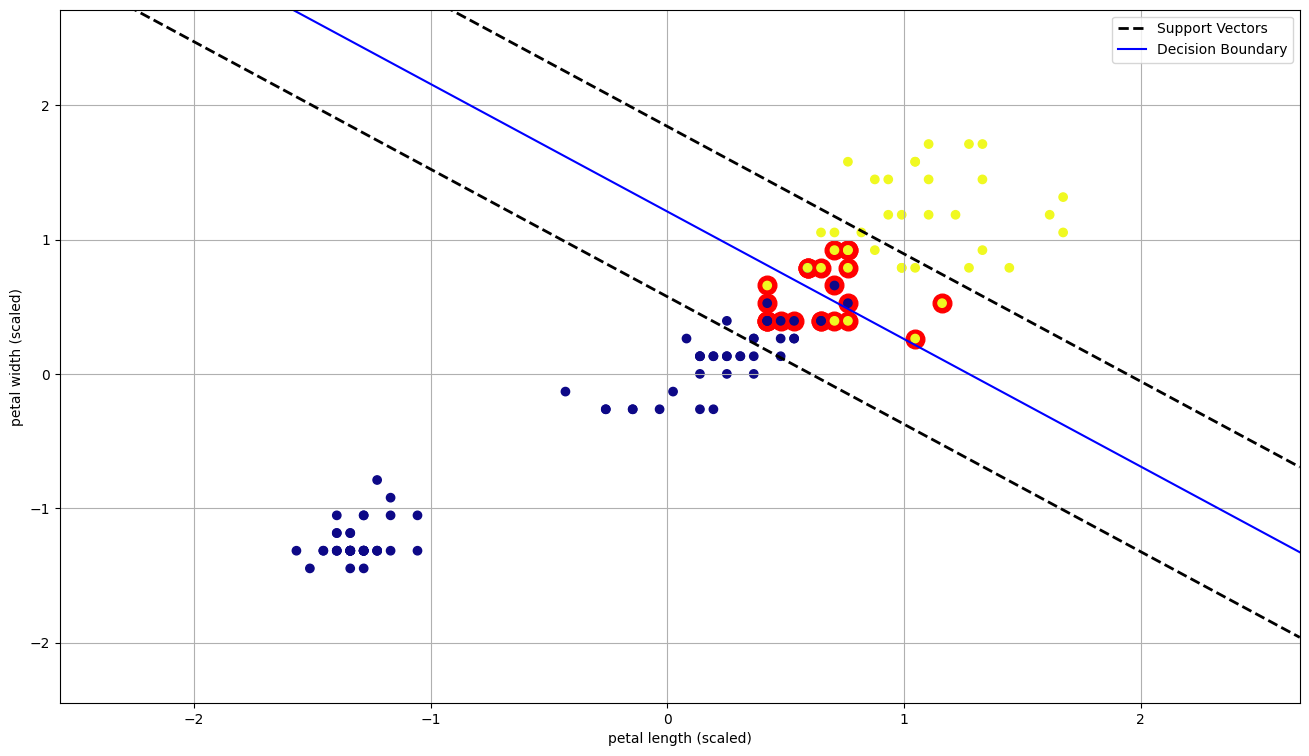

In [2361]:
# todo: need to check what is actually a margin violation
plot_decision_boundary_from_weights(svm, X_train, y_train, X_train, "petal length (scaled)", "petal width (scaled)")

In [2362]:
# Cross validation
from sklearn.model_selection import cross_val_score

# The aim was to show you that some observations are misclassified. Meaning some are on the
# other side of the decision boundary. But it really depends on how the dataset is split since
# there are only a few datapoints the complete dataset.

scores = cross_val_score(svm, X_scaled, y, cv=10, scoring="accuracy")
scores


array([1.        , 1.        , 1.        , 1.        , 0.93333333,
       0.86666667, 1.        , 0.86666667, 0.86666667, 1.        ])

# ------------------------------------------------------------------------------------------------
# EXAMPLE 2
My fiddling around with the code.

In [2363]:
# CREATE DATA
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=4)

In [2364]:
X

array([[ 0.83357083,  4.49545871],
       [11.35068209, -0.24118328],
       [ 0.25477849, -3.78703385],
       ...,
       [-0.84772574, -4.48107591],
       [ 9.14407984,  1.76759479],
       [ 6.25001411,  5.78109299]])

In [2365]:
y

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,

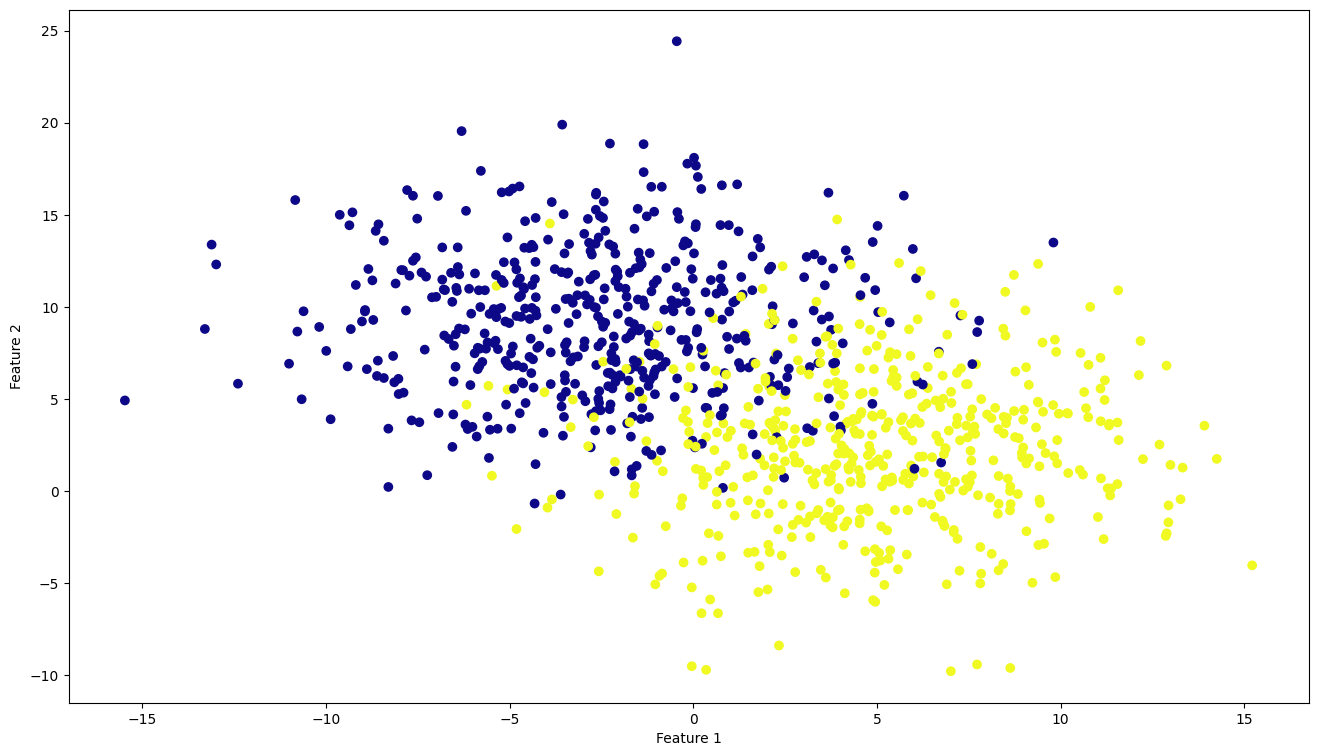

In [2366]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [2367]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [2368]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [2369]:
# TRAIN MODEL
svm = MyLinearSVC(C=10, eta0=1, eta_d=1000, n_epochs=20000)

svm.fit(X_train, y_train)

MyLinearSVC(C=10, eta_d=1000, n_epochs=20000)

In [2370]:
# EVALUATE MODEL
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [2371]:
svm.intercept_, svm.coef_

(array([-0.03402733]),
 array([[ 1.61505155],
        [-1.34885955]]))

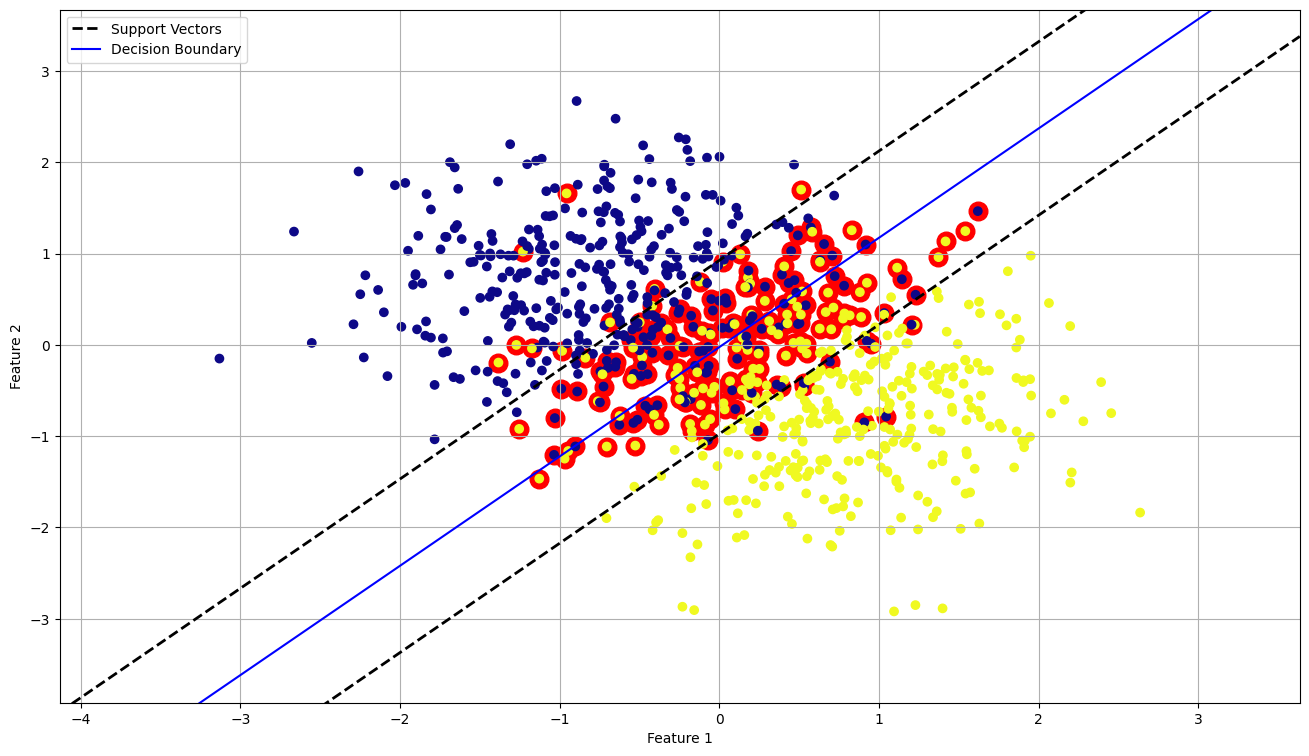

In [2372]:
plot_decision_boundary_from_weights(svm, X_train, y_train, X_train)

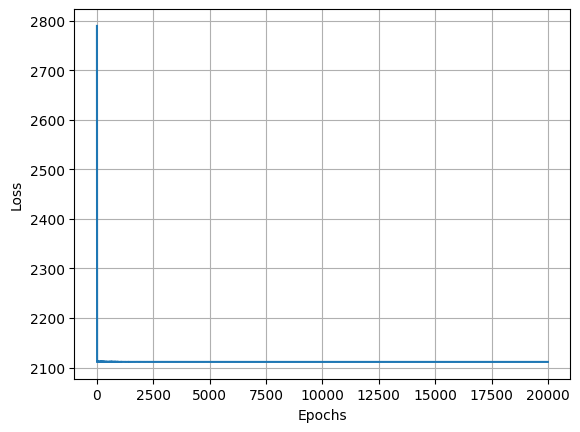

In [2373]:
plt.plot(range(svm.n_epochs), svm.Js)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [2374]:
# Just an example how might "self" change based on the class inheritance. But I think pycharm has it bugged also sometimes (at least in jupyter I guess).
class Parent:
    # def __init__(self):
    #     self.parent_attribute = "I am from Parent"
    parent_attribute = "I am from Parent"
    
    def parent_method(self):
        return "This is a method from Parent"

class Child(Parent):
    def __init__(self):
        # super().__init__()
        self.child_attribute = "I am from Child"
    
    def parent_method(self):
        ...
    
    def some_method(self):
        print(self.parent_attribute)  # Inherited from Parent
        print(self.child_attribute)   # Defined in Child
        print(self.parent_method())   # Inherited from Parent
        
